In [2]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [4]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize image to 224x224
    transforms.Lambda(lambda img: img.convert("RGB")), # convert all images to RGB
    transforms.ToTensor(), # image normalization to tensor values from 0 to 1
])

In [5]:
def load_images_from_folder(folder):
    images = []
    # Check if the folder exists and is a directory
    if not os.path.isdir(folder):
        print(f"Warning: Folder not found or is not a directory: {folder}")
        return None  # Or return an empty tensor as an alternative

    for filename in os.listdir(folder):
        if filename.endswith(".jpg"): # extract all jpg files
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = transform(img) # image processing
            images.append(img)

    if not images:
        print(f"Warning: No .jpg files found in folder: {folder}")
        return None  # Or return an empty tensor

    return torch.stack(images) # stack all images as a tensor for vectorization

In [6]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Cat vs Dog/" # put your file directory from google drive

In [7]:

# For train set (train folder is subdivided into two folders of cats and dogs)
train_cats_path = os.path.join(base_path, "train/cats")
train_dogs_path = os.path.join(base_path, "train/dogs")


In [8]:
# For test set (train folder is subdivided into two folders of cats and dogs)
test_cats_path = os.path.join(base_path, "test/cats")
test_dogs_path = os.path.join(base_path, "test/dogs")

In [9]:
# Load tensors for train and test sets
train_cats_tensors = load_images_from_folder(train_cats_path)
train_dogs_tensors = load_images_from_folder(train_dogs_path)
test_cats_tensors = load_images_from_folder(test_cats_path)
test_dogs_tensors = load_images_from_folder(test_dogs_path)


In [10]:
# Create labels (0 for cat and 1 for dog)
train_labels = torch.cat([torch.zeros(train_cats_tensors.size(0)), torch.ones(train_dogs_tensors.size(0))])
test_labels = torch.cat([torch.zeros(test_cats_tensors.size(0)), torch.ones(test_dogs_tensors.size(0))])

In [11]:
# Concatenate cats and dogs tensor for train and test sets as well as their labels
train_dataset = TensorDataset(torch.cat([train_cats_tensors, train_dogs_tensors]), train_labels)
test_dataset = TensorDataset(torch.cat([test_cats_tensors, test_dogs_tensors]), test_labels)

In [12]:

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# Load pretrained ResNet-50 model
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [14]:
# Freeze convolutional layers
for param in model.parameters():
    param.requires_grad = False

In [15]:
# Modify the fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Change output to 1 feature for binary classification
    nn.Sigmoid()  # Apply sigmoid to get probabilities
)


In [16]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

In [23]:
# Lists to store accuracy for each epoch
train_accuracies = []
test_accuracies = []

In [24]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward ppropagation
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy on the train data
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100*correct_train/total_train
    train_accuracies.append(train_accuracy)
     # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')



Epoch [1/20], Loss: 0.0595, Train Accuracy: 99.10%, Test Accuracy: 93.57%
Epoch [2/20], Loss: 0.0610, Train Accuracy: 98.74%, Test Accuracy: 92.86%
Epoch [3/20], Loss: 0.0648, Train Accuracy: 98.92%, Test Accuracy: 93.57%
Epoch [4/20], Loss: 0.0841, Train Accuracy: 97.13%, Test Accuracy: 93.57%
Epoch [5/20], Loss: 0.0636, Train Accuracy: 98.20%, Test Accuracy: 92.14%
Epoch [6/20], Loss: 0.0650, Train Accuracy: 97.67%, Test Accuracy: 93.57%
Epoch [7/20], Loss: 0.0502, Train Accuracy: 99.46%, Test Accuracy: 92.86%
Epoch [8/20], Loss: 0.0517, Train Accuracy: 99.64%, Test Accuracy: 92.86%
Epoch [9/20], Loss: 0.0634, Train Accuracy: 97.85%, Test Accuracy: 92.14%
Epoch [10/20], Loss: 0.0567, Train Accuracy: 98.92%, Test Accuracy: 93.57%
Epoch [11/20], Loss: 0.0611, Train Accuracy: 98.38%, Test Accuracy: 92.86%
Epoch [12/20], Loss: 0.0654, Train Accuracy: 98.03%, Test Accuracy: 92.86%
Epoch [13/20], Loss: 0.0571, Train Accuracy: 98.56%, Test Accuracy: 92.14%
Epoch [14/20], Loss: 0.0526, Train

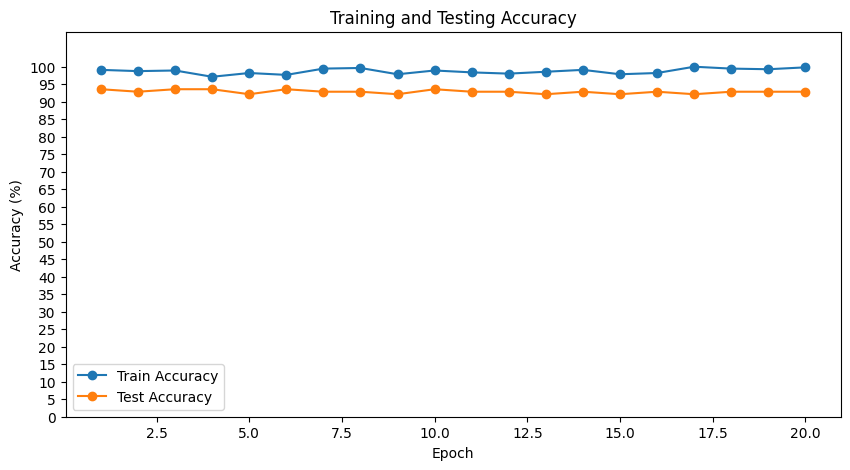

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')

# Set y-axis ticks to be at a gap of 5
plt.yticks(np.arange(0, 101, 5))

plt.ylim(0, 110)
plt.legend()
plt.show()

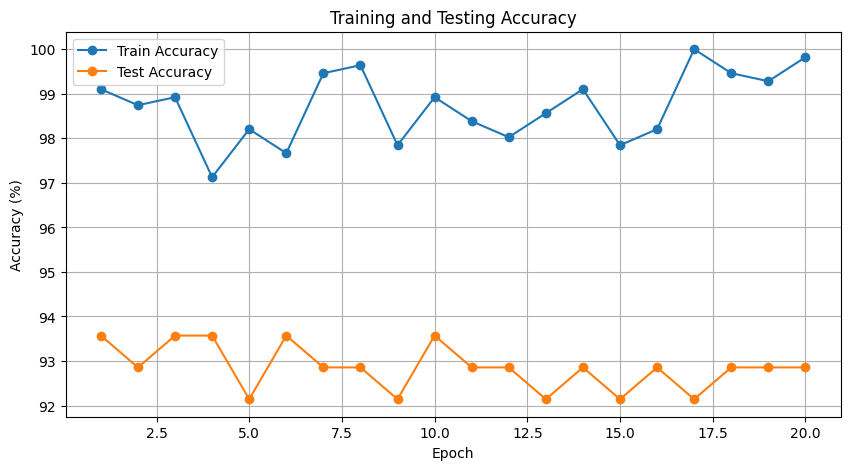

In [26]:
# Plotting training and testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

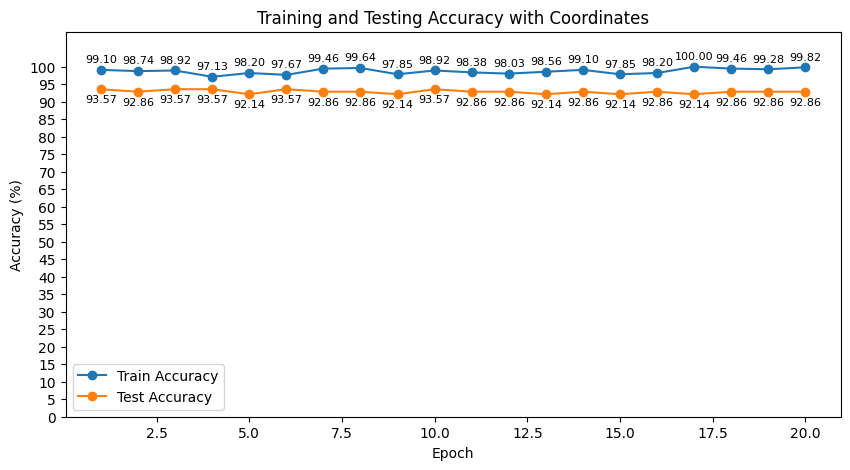

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_accuracies and test_accuracies are defined
# and you have the correct num_epochs

plt.figure(figsize=(10, 5))

# Plotting training accuracy with markers and text labels
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
for i, (x, y) in enumerate(zip(range(1, num_epochs + 1), train_accuracies)):
    plt.text(x, y + 1.5, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Plotting testing accuracy with markers and text labels
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
for i, (x, y) in enumerate(zip(range(1, num_epochs + 1), test_accuracies)):
    plt.text(x, y - 1.5, f'{y:.2f}', ha='center', va='top', fontsize=8)

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy with Coordinates')

# Set y-axis ticks to be at a gap of 5
plt.yticks(np.arange(0, 101, 5))

plt.ylim(0, 110)
plt.legend()
plt.show()

In [30]:
# Save the model for website deployment
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Cat vs Dog/Model.pth')

In [29]:
# Save the model for website deployment
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Cat vs Dog/Model.ipynb')